<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Demo 7.2.1: Ensemble Methods

INSTRUCTIONS:

- Run the cells
- Observe and understand the results
- Answer the questions

This is an excerpt from the [Introduction to Ensembling/Stacking in Python
](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python) by **Anisotropic** on **Kaggle**.
Credits also to:
- **Faron**: Mathias Müller, Data Scientist @ H2O.ai, Diplom (eq. MSc.) in Computer Science | HU-Berlin (zhryyrezng84@tznvy.pbz)
- **Sina**: AI Student at IUSTTehran, Tehran Province, Iran (https://sinakhorami.github.io)

## Dataset: Titanic
The full Titanic dataset is available from the Department of Biostatistics at the [Vanderbilt University School of Medicine](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv) in several formats. 

The [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/) is the website of reference regarding the Titanic. It contains all the facts, history, and data surrounding the Titanic, including a full list of passengers and crew members. 

The Titanic dataset is also the subject of the introductory competition on [Kaggle.com](https://www.kaggle.com/c/titanic). Requires opening an account.

### Overview
The data has been split into two groups:
- Training set (`train.csv`)
- Test set (`test.csv`)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

### Data Dictionary
- **PassengerID**: A column added by Kaggle to identify each row and make submissions easier
- **Survived**: Whether the passenger survived or not and the value we are predicting (`0`=No, `1`=Yes)
- **Pclass**: The class of the ticket the passenger purchased (`1`=1st, `2`=2nd, `3`=3rd)
- **Sex**: The passenger's sex
- **Age**: The passenger's age in years
- **SibSp**: The number of siblings or spouses the passenger had aboard the Titanic
- **Parch**: The number of parents or children the passenger had aboard the Titanic
- **Ticket**: The passenger's ticket number
- **Fare**: The fare the passenger paid
- **Cabin**: The passenger's cabin number
- **Embarked**: The port where the passenger embarked `C`=Cherbourg, `Q`=Queenstown, `S`=Southampton)

### Variable Notes
- **pclass**: A proxy for socio-economic status (SES)
    - _1st_ = Upper
    - _2nd_ = Middle
    - _3rd_ = Lower
- **age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- **sibsp**: The dataset defines family relations in this way
    - _Sibling_ = brother, sister, stepbrother, stepsister
    - _Spouse_ = husband, wife (mistresses and fiancés were ignored)
- **parch**: The dataset defines family relations in this way
    - _Parent_ = mother, father
    - _Child_ = daughter, son, stepdaughter, stepson
    - Some children travelled only with a nanny, therefore `parch=0` for them

In [1]:
## Import Libraries

import re

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
## Loading the dataset

# Load in the train and test datasets
train = pd.read_csv('/home/gaio/Documents/GitHub/iod-linux/DATA/titanic_train.csv')
test = pd.read_csv('/home/gaio/Documents/GitHub/iod-linux/DATA/titanic_test.csv')

In [3]:
## Check the data

# About train
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# About test
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Data Cleaning, Exploration and Feature Engineering

In [5]:
# Extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ''

full_data = [train, test]
# calculate quantiles
fare_quant = train.Fare.quantile([.25, .5, .75])
age_quant = train.Age.quantile([0.2, 0.4, 0.6, 0.8])

verbose = True

# Gives the length of the name
for dataset in full_data:
    dataset['Name_length'] = dataset['Name'].apply(len)

# Feature that tells whether a passenger had a cabin on the Titanic
for dataset in full_data:
    dataset['Has_Cabin'] = dataset['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
# train['CategoricalFare'] = pd.qcut(train['Fare'], 4, duplicates = 'drop')

# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    dataset['Age'] = dataset['Age'].apply(lambda x: x if x is None else (np.random.randint(age_avg - age_std, age_avg + age_std)))
    dataset['Age'] = dataset['Age'].astype(int)
# train['CategoricalAge'] = pd.cut(train['Age'], 5, duplicates = 'drop')

# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# Group all non-common titles into one single grouping 'Rare'
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
#     dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']                               = 0
#     dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
#     dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
#     dataset.loc[ dataset['Fare'] > 31, 'Fare']                                  = 3
#     dataset['Fare'] = dataset['Fare'].astype(int)
    for i in range(len(fare_quant) + 1):
        if i == 0:
            p = fare_quant.iloc[i]
            dataset.loc[ dataset['Fare'] <= p, 'Fare'] = i # 0
            if verbose:
                print('Categorising Fare')
                print('%d: > %7.4f and <= %7.4f ' % (i, dataset['Fare'].min(), p))
            continue
        if i == len(fare_quant):
            p_1 = fare_quant.iloc[i - 1]
            dataset.loc[ dataset['Fare'] > p_1, 'Fare'] = i # len(quant)
            if verbose:
                print('%d: > %7.4f' % (i, p_1))
            continue
        if i < len(fare_quant):
            p = fare_quant.iloc[i]
            p_1 = fare_quant.iloc[i - 1]
            dataset.loc[(dataset['Fare'] > p_1) & (dataset['Fare'] <= p), 'Fare'] = i
            if verbose:
                print('%d: > %7.4f and <= %7.4f' % (i, p_1, p))
    
    # Mapping Age
#     dataset.loc[ dataset['Age'] <= 16, 'Age']                          = 0
#     dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
#     dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
#     dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
#     dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4
    for i in range(len(age_quant) + 1):
        if i == 0:
            p = age_quant.iloc[i]
            dataset.loc[ dataset['Age'] <= p, 'Age'] = i # 0
            if verbose:
                print('Categorising Age')
                print('%d: > %7.4f and <= %7.4f ' % (i, dataset['Age'].min(), p))
            continue
        if i == len(age_quant):
            p_1 = age_quant.iloc[i - 1]
            dataset.loc[ dataset['Age'] > p_1, 'Age'] = i # len(quant)
            if verbose:
                print('%d: > %7.4f' % (i, p_1))
            continue
        if i < len(age_quant):
            p = age_quant.iloc[i]
            p_1 = age_quant.iloc[i - 1]
            dataset.loc[(dataset['Age'] > p_1) & (dataset['Age'] <= p), 'Age'] = i
            if verbose:
                print('%d: > %7.4f and <= %7.4f' % (i, p_1, p))

    verbose = False

Categorising Fare
0: >  0.0000 and <=  7.9104 
1: >  7.9104 and <= 14.4542
2: > 14.4542 and <= 31.0000
3: > 31.0000
Categorising Age
0: >  0.0000 and <= 19.0000 
1: > 19.0000 and <= 25.0000
2: > 25.0000 and <= 31.8000
3: > 31.8000 and <= 41.0000
4: > 41.0000


In [6]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
# train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [7]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    int64  
 3   Age          891 non-null    int64  
 4   Parch        891 non-null    int64  
 5   Fare         891 non-null    float64
 6   Embarked     891 non-null    int64  
 7   Name_length  891 non-null    int64  
 8   Has_Cabin    891 non-null    int64  
 9   FamilySize   891 non-null    int64  
 10  IsAlone      891 non-null    int64  
 11  Title        891 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 83.7 KB
None


,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,2,0,0.0,0,23,0,2,0,1
1,1,1,0,3,0,3.0,1,51,1,2,0,3
2,1,3,0,3,0,1.0,0,22,0,1,1,2
3,1,1,0,2,0,3.0,0,44,1,2,0,3
4,0,3,1,2,0,1.0,0,24,0,1,1,1


In [8]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       418 non-null    int64  
 1   Sex          418 non-null    int64  
 2   Age          418 non-null    int64  
 3   Parch        418 non-null    int64  
 4   Fare         418 non-null    float64
 5   Embarked     418 non-null    int64  
 6   Name_length  418 non-null    int64  
 7   Has_Cabin    418 non-null    int64  
 8   FamilySize   418 non-null    int64  
 9   IsAlone      418 non-null    int64  
 10  Title        418 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 36.0 KB
None


,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,0,0,0.0,2,16,0,1,1,1
1,3,0,2,0,0.0,0,32,0,2,0,3
2,2,1,3,0,1.0,2,25,0,1,1,1
3,3,1,1,0,1.0,0,16,0,1,1,1
4,3,0,1,1,1.0,0,44,0,3,0,3


## Pearson Correlation Heatmap
Check correlation of the features to see how related one feature is to the next.

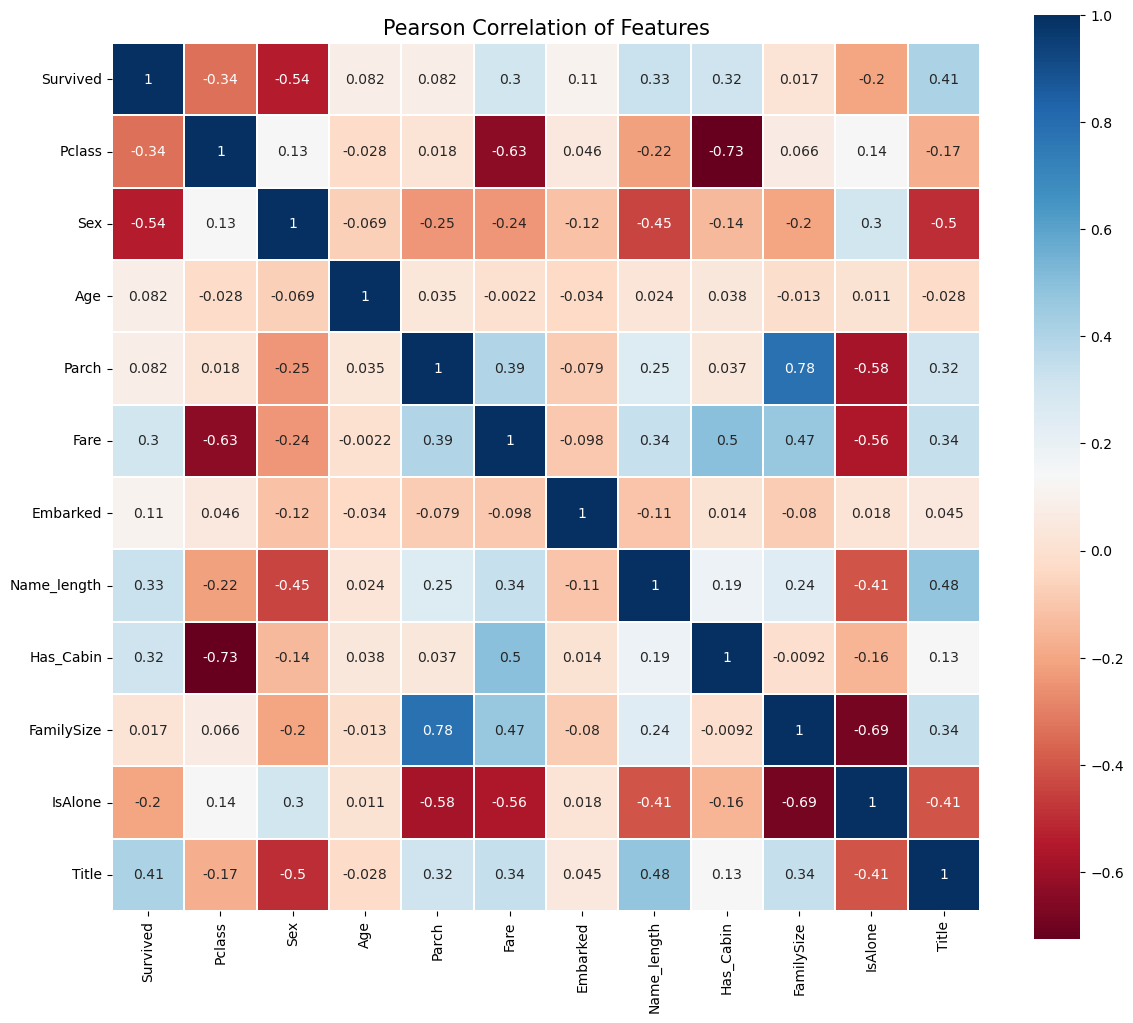

In [9]:
colormap = plt.cm.RdBu
plt.figure(figsize = (14, 12))
plt.title('Pearson Correlation of Features', size = 15)
sns.heatmap(train.astype(float).corr(),
            linewidths = 0.1,
            vmax = 1.0,
            square = True,
            cmap = colormap,
            linecolor = 'white',
            annot = True)
plt.show()

**QUESTION**: What does the chart say?

The Pearson Correlation plot can tell that there are not too many features strongly correlated with one another. 

This is good because:
- this means that there is not much redundant or superfluous data in the training set
- each feature carries with it some unique information

The two most correlated features are `FamilySize` and `Parch` (Parents and Children)

## Pairplots

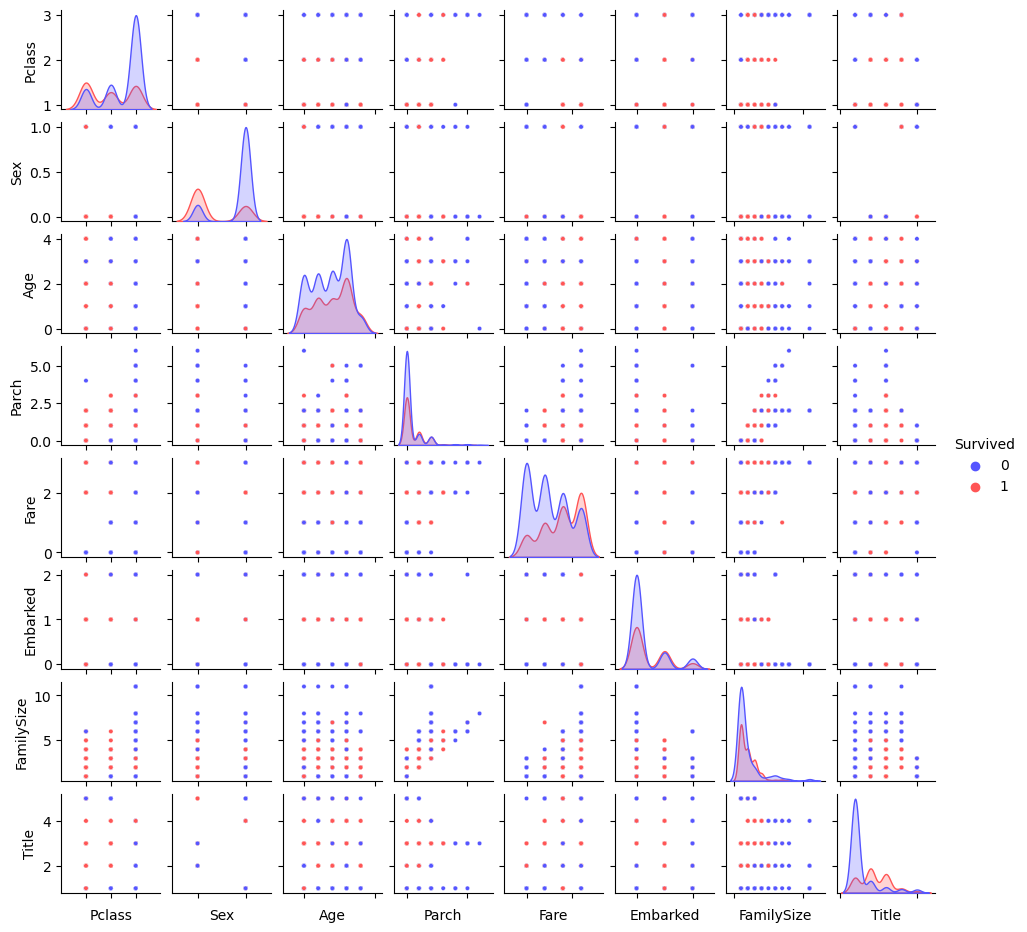

In [10]:
features = ['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title']
g = sns.pairplot(
    train[features],
    hue = 'Survived',
    palette = 'seismic',
    size = 1.2,
    diag_kind = 'kde',
    diag_kws = dict(shade = True),
    plot_kws = dict(s = 10))
g.set(xticklabels = [])
plt.show()

## Ensembling & Stacking models

#### Helpers via Python Classes
Here we invoke the use of Python's classes to help make it more convenient. In short, a class helps to extend some code/program for creating objects as well as to implement functions and methods specific to that class.

In the code below, a class `SklearnHelper` allows to extend the inbuilt methods (such as train, predict and fit) common to all the `Scikit-Learn` classifiers. This cuts out redundancy as it avoids to write the same methods many times when invoking many different classifiers.

In [11]:
# Some common parameters
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits = NFOLDS)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed = 0, params = None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def predict_proba(self, x):
        return self.clf.predict_proba(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        return self.clf.fit(x, y).feature_importances_

### Out-of-Fold Predictions
Stacking uses predictions of base classifiers as input for training to a second level model.

However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second level training.

This runs the risk of the base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [12]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain, ))
    oof_test = np.zeros((ntest, ))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis = 0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

### Generating the Base First Level Models
The first level classification models can all be conveniently invoked via the `Scikit-Learn` library and are listed as follows:

- Random Forest classifier
- Extra Trees classifier
- AdaBoost classifier
- Gradient Boosting classifier
- Support Vector classifier

#### Parameters

A quick summary of the parameters:

- **n_jobs**: Number of cores used for the training process. If set to -1, all cores are used.
- **n_estimators**: Number of classification trees in your learning model (set to 10 per default).
- **max_depth**: Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep.
- **verbose**: Controls whether to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

Please check out the full description via the official [Scikit-Learn](http://scikit-learn.org/) website.

In [13]:
# Set the parameters for the classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
#     'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Trees parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
#     'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
#     'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025,
    'probability' : True
}

In [14]:
# Create the objects that represent our the models
rf  = SklearnHelper(clf = RandomForestClassifier,     seed = SEED, params = rf_params)
et  = SklearnHelper(clf = ExtraTreesClassifier,       seed = SEED, params = et_params)
ada = SklearnHelper(clf = AdaBoostClassifier,         seed = SEED, params = ada_params)
gb  = SklearnHelper(clf = GradientBoostingClassifier, seed = SEED, params = gb_params)
svc = SklearnHelper(clf = SVC,                        seed = SEED, params = svc_params)

In [15]:
# Create Numpy arrays to feed into the models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis = 1)
x_train = train.values
x_test = test.values

In [16]:
# Create our OOF (Out-of-Fold) train and test predictions
# These base results will be used as new features
et_oof_train,  et_oof_test  = get_oof(et,  x_train, y_train, x_test) # Extra Trees
rf_oof_train,  rf_oof_test  = get_oof(rf,  x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train,  gb_oof_test  = get_oof(gb,  x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # Support Vector Classifier

print('Training is complete')

Training is complete


### Feature importance from the different classifiers
The importance of the various features in the training and test sets is available from the first level classifiers with one very simple line of code.

As per the `Scikit-Learn` documentation, most of the classifiers are built in with an attribute which returns feature importances by refering to the `.featureimportances_` attribute.

**NOTE**: SVC does not have the `.featureimportances_` attribute.

In [17]:
# Create a dataframe with features
cols = train.columns.values
feature_dataframe = pd.DataFrame({
    'Feature':        cols,
    'Random Forest':  rf.feature_importances(x_train, y_train),
    'Extra Trees':    et.feature_importances(x_train, y_train),
    'AdaBoost':       ada.feature_importances(x_train, y_train),
    'Gradient Boost': gb.feature_importances(x_train, y_train)
})

In [18]:
feature_dataframe

,Feature,Random Forest,Extra Trees,AdaBoost,Gradient Boost
0,Pclass,0.120366,0.121295,0.024,0.089949
1,Sex,0.200742,0.381515,0.014,0.008970
2,Age,0.032195,0.022191,0.008,0.074232
3,Parch,0.021142,0.017355,0.066,0.008181
4,Fare,0.073777,0.055583,0.020,0.055298
5,Embarked,0.024461,0.028882,0.012,0.029057
6,Name_length,0.107355,0.047731,0.726,0.164179
7,Has_Cabin,0.064163,0.082091,0.016,0.031997
8,FamilySize,0.068197,0.044977,0.042,0.108845
9,IsAlone,0.014173,0.022103,0.004,0.007257


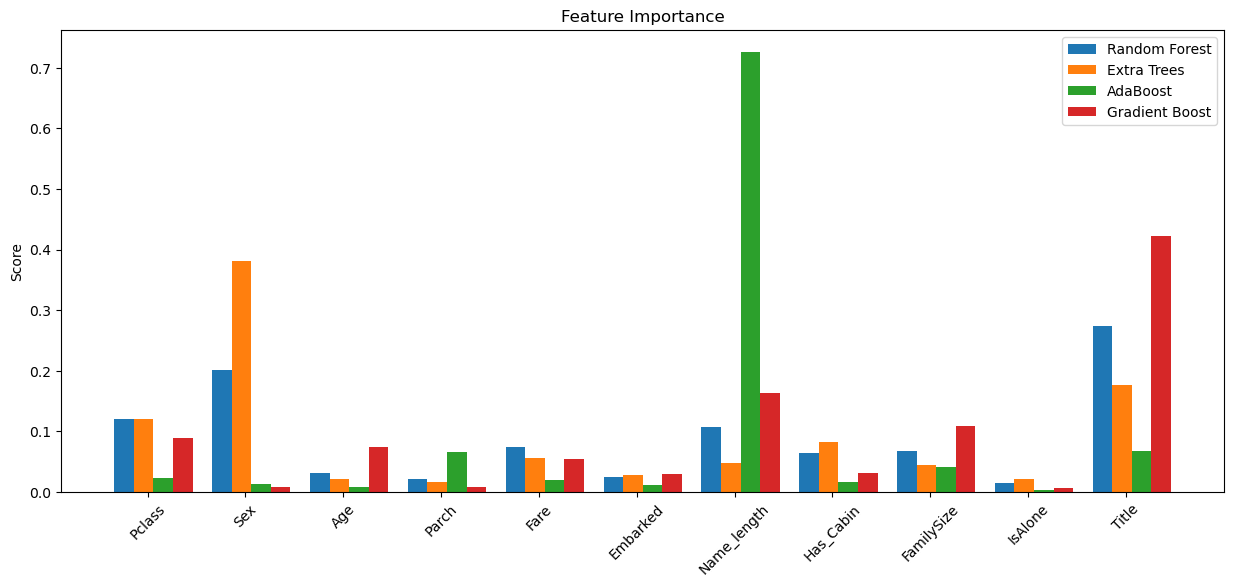

In [19]:
fig = plt.figure(figsize = (15, 6))

ind = np.arange(len(cols)) 
width = 0.2

for i, m in enumerate(feature_dataframe.columns[1:]):
    plt.bar(ind + ((i - 1 - width) * width), feature_dataframe[m], width, label = m)
    
plt.title('Feature Importance')
plt.xticks(ind, cols, rotation = 45)
plt.ylabel('Score')
plt.legend()
plt.show()

In [20]:
# Create a new column containing the average of values
feature_dataframe['Mean'] = feature_dataframe.mean(axis = 1) # axis = 1 computes the mean row-wise
feature_dataframe

,Feature,Random Forest,Extra Trees,AdaBoost,Gradient Boost,Mean
0,Pclass,0.120366,0.121295,0.024,0.089949,0.088903
1,Sex,0.200742,0.381515,0.014,0.008970,0.151307
2,Age,0.032195,0.022191,0.008,0.074232,0.034155
3,Parch,0.021142,0.017355,0.066,0.008181,0.028169
4,Fare,0.073777,0.055583,0.020,0.055298,0.051164
5,Embarked,0.024461,0.028882,0.012,0.029057,0.023600
6,Name_length,0.107355,0.047731,0.726,0.164179,0.261317
7,Has_Cabin,0.064163,0.082091,0.016,0.031997,0.048563
8,FamilySize,0.068197,0.044977,0.042,0.108845,0.066005
9,IsAlone,0.014173,0.022103,0.004,0.007257,0.011883


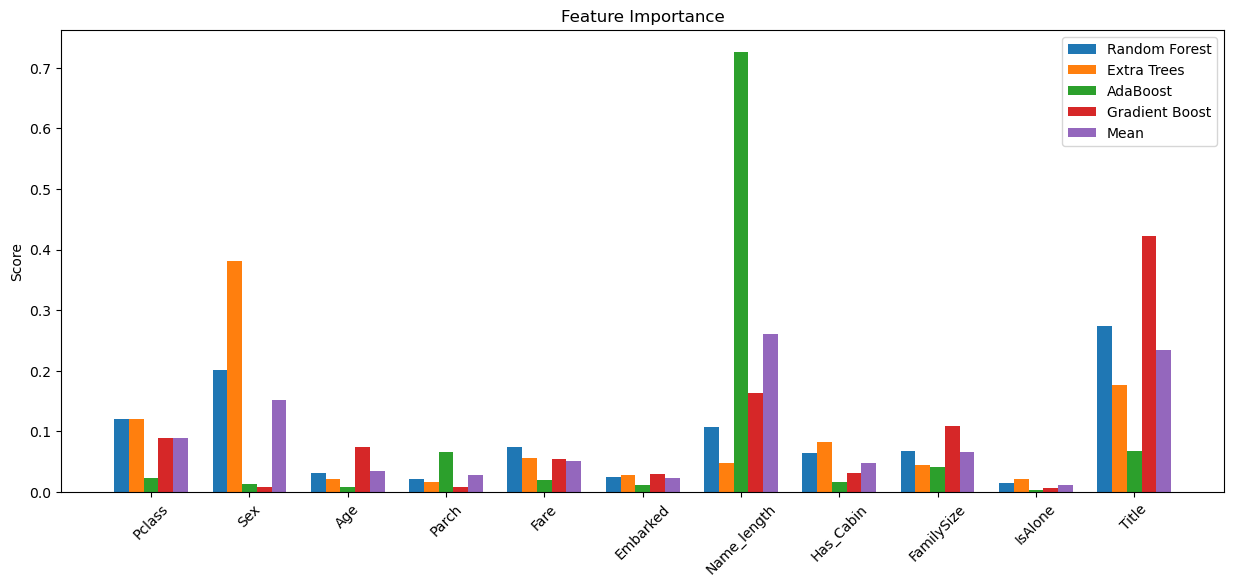

In [21]:
fig = plt.figure(figsize = (15, 6))

ind = np.arange(len(cols)) 
width = 0.15

for i, m in enumerate(feature_dataframe.columns[1:]):
    plt.bar(ind + ((i - 2) * width), feature_dataframe[m], width, label = m)

plt.title('Feature Importance')
plt.xticks(ind, cols, rotation = 45)
plt.ylabel('Score')
plt.legend()
plt.show()

In [22]:
def show_summary_report(actual, prediction):

    if isinstance(actual, pd.Series):
        actual = actual.values
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(float)
        
    prediction_int = np.round(prediction)

    accuracy_ = accuracy_score(actual, prediction_int)
    precision_ = precision_score(actual, prediction_int)
    recall_ = recall_score(actual, prediction_int)
    roc_auc_ = roc_auc_score(actual, prediction)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction_int)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction_int)
    average_precision = average_precision_score(actual, prediction_int)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, prediction)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()
    
    return (accuracy_, precision_, recall_, roc_auc_)

### Summary for the First Level
**NOTE**: As the dataset is given from a Kaggle competition, the output values for the test set are **not** known. The summary report below are from the training data.

*****************
* Random Forest *
*****************
Accuracy : 0.8653 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8447 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7953 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9203                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


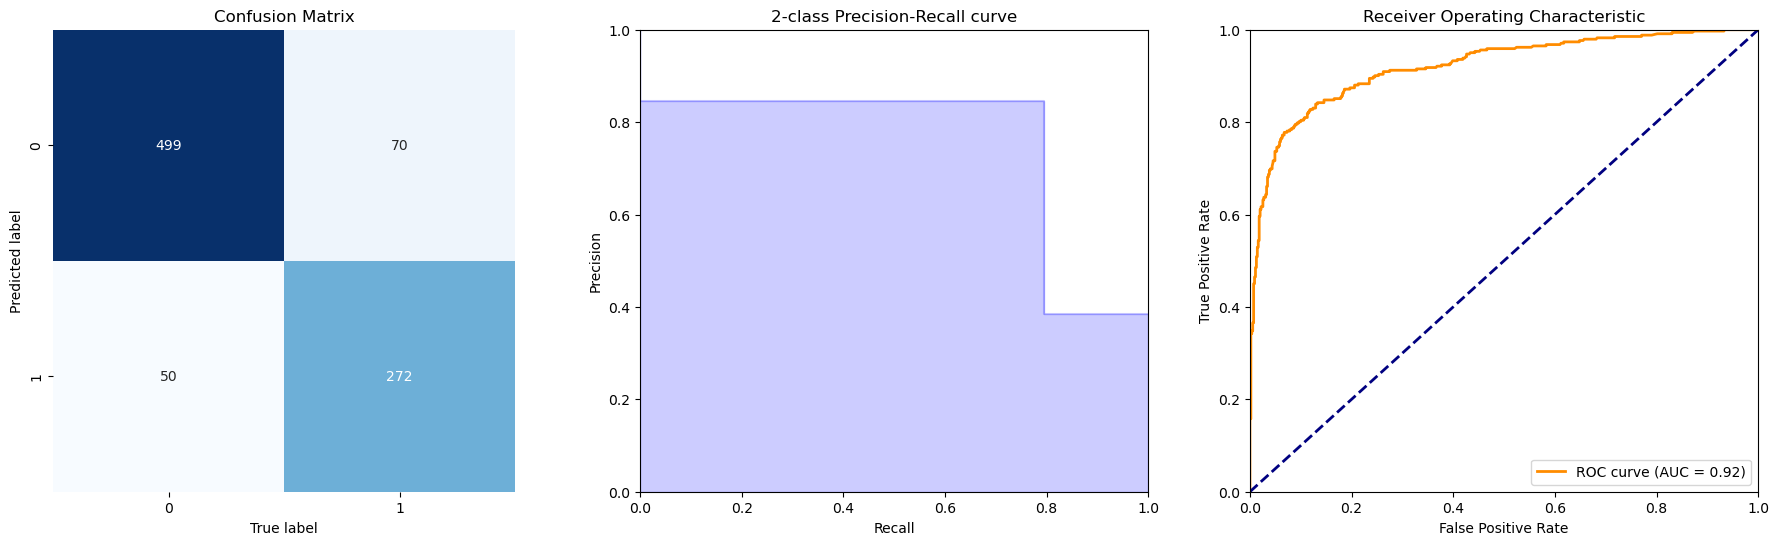


***************
* Extra Trees *
***************
Accuracy : 0.8698 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8767 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7690 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9361                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


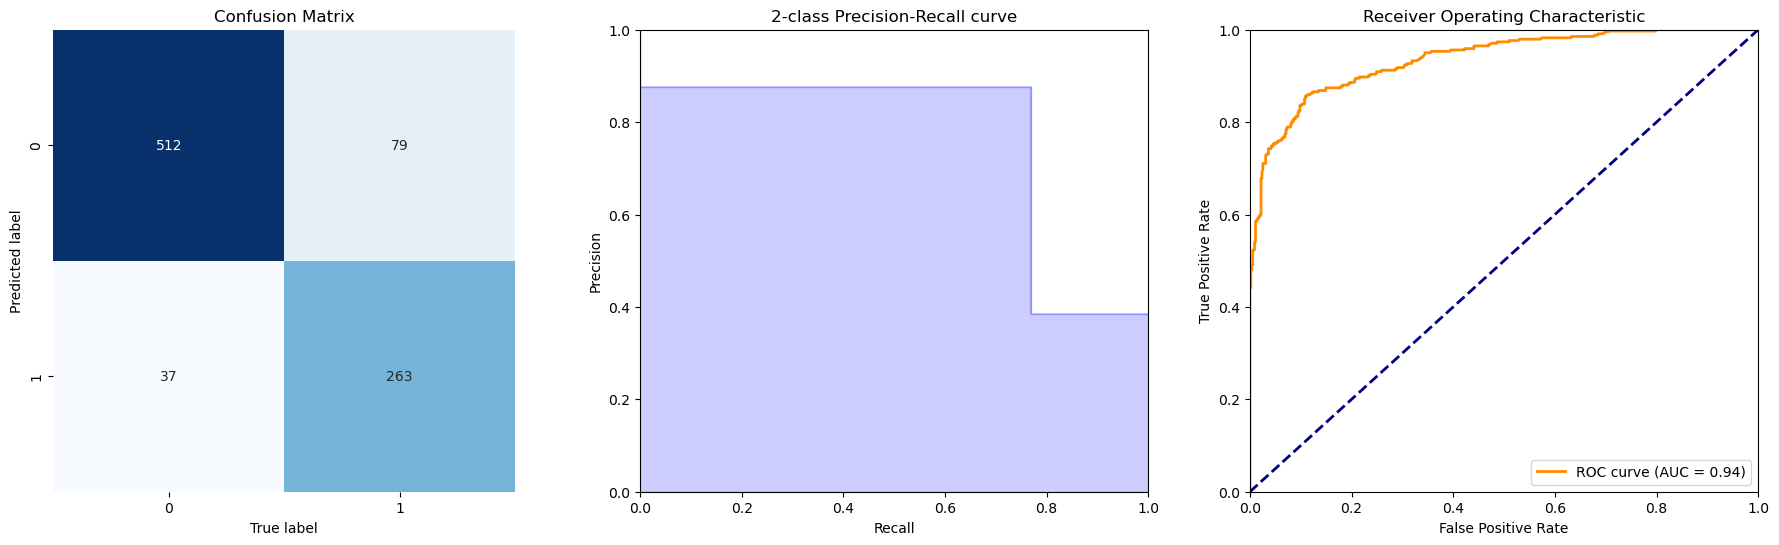


************
* AdaBoost *
************
Accuracy : 0.8406 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8145 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7573 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9031                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


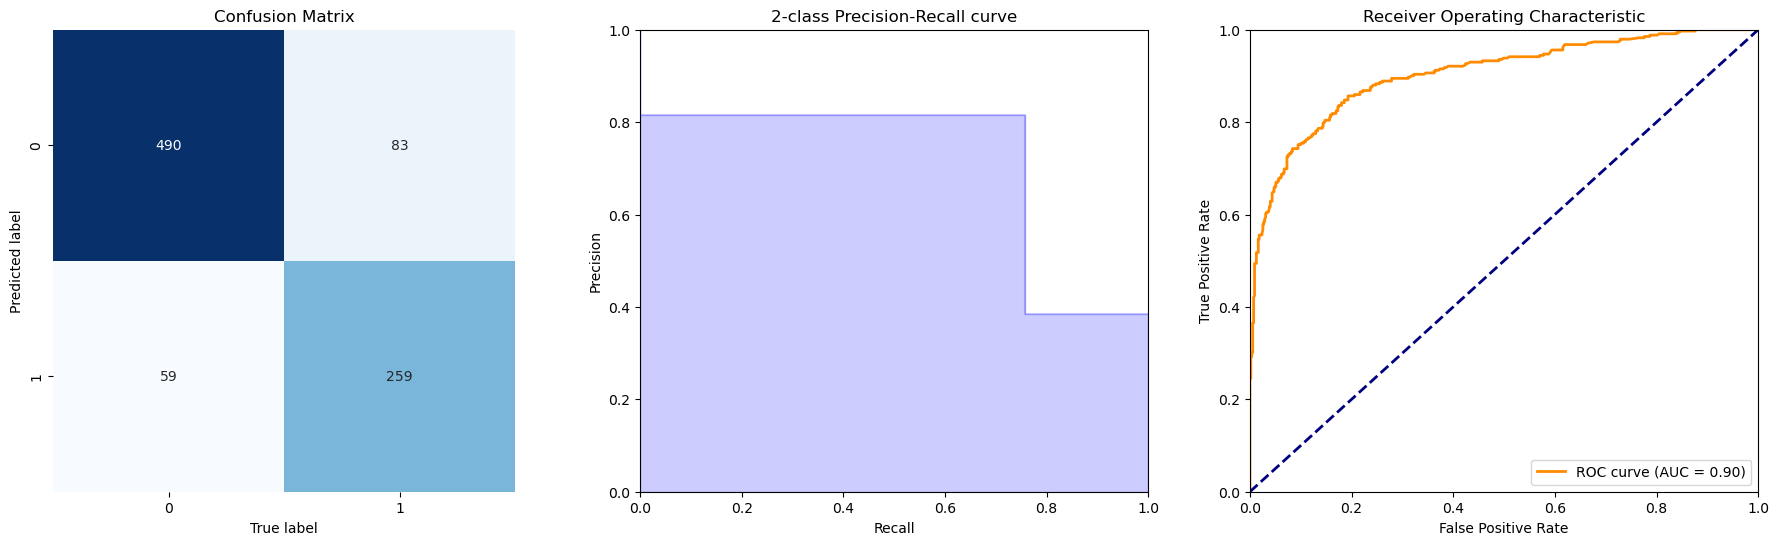


******************
* Gradient Boost *
******************
Accuracy : 0.9820 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9910 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9620 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9992                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


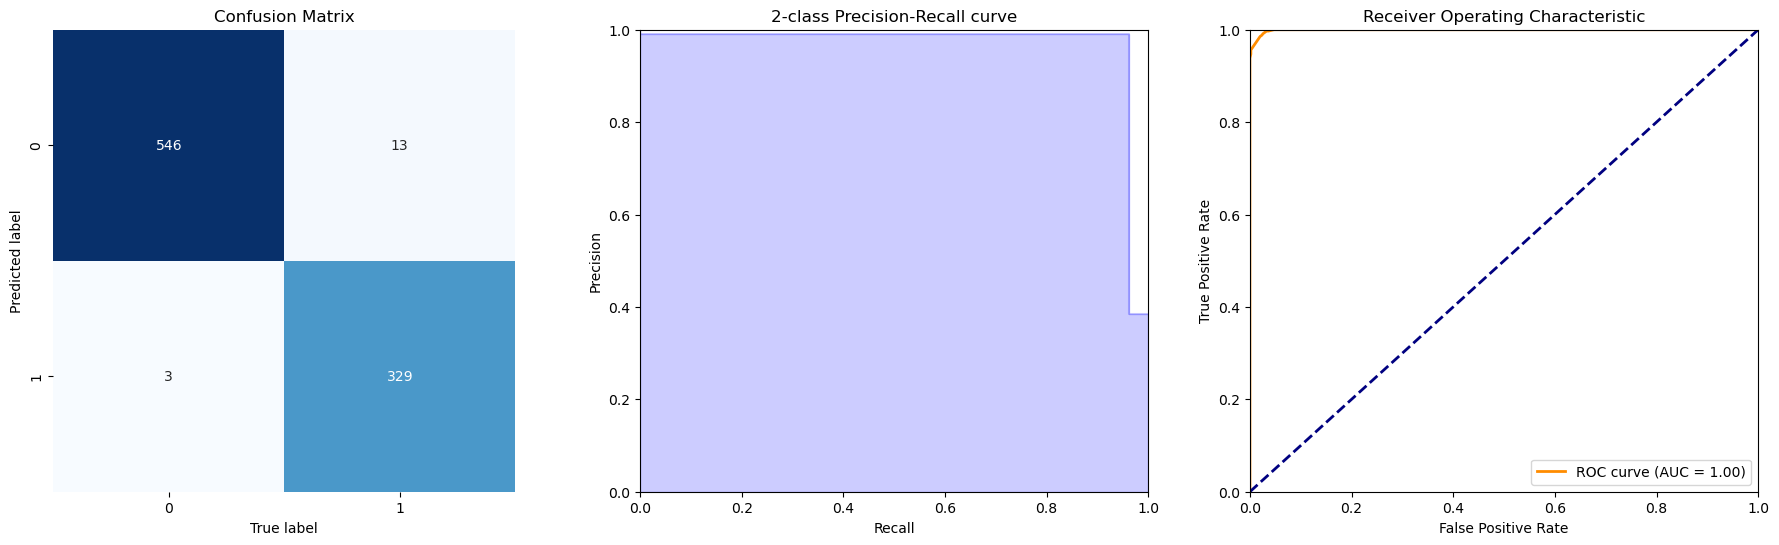


*****************************
* Support Vector Classifier *
*****************************
Accuracy : 0.8137 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7651 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7427 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8501                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


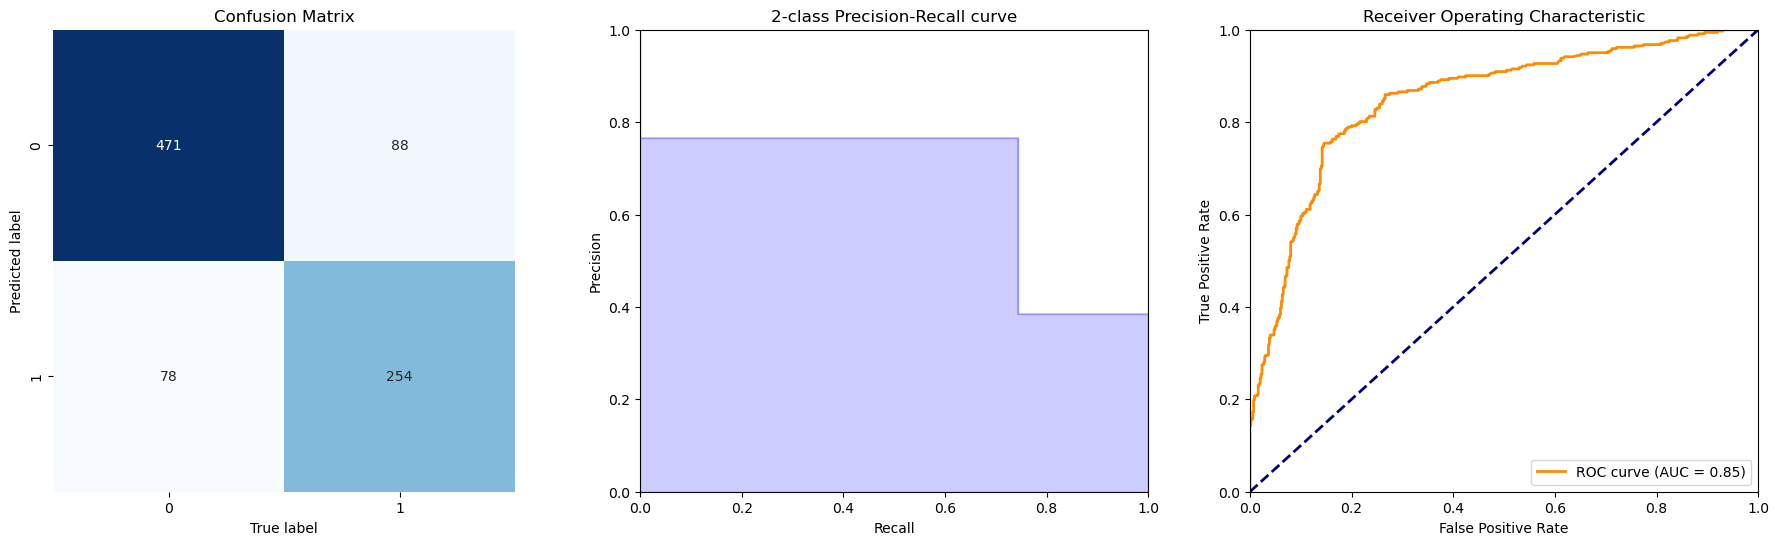

In [23]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Random Forest', 'Extra Trees', 'AdaBoost', 'Gradient Boost', 'Support Vector Classifier']
for i, m in enumerate([rf, et, ada, gb, svc]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    predictions = m.predict_proba(x_train)[:,1]
    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_train, predictions)
    # keep the results
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()

## Second Level Predictions from the First Level Output
### First level output as new features
One can think of building a new set of features from the first level predictions to be used as training data for the next classifier.

The code below have the first level predictions from the earlier classifiers as new columns and trains the next classifier from those.

In [24]:
base_predictions_train = pd.DataFrame({
    'RandomForest': rf_oof_train.ravel(),
    'ExtraTrees': et_oof_train.ravel(),
    'AdaBoost': ada_oof_train.ravel(),
    'GradientBoost': gb_oof_train.ravel()
})
print('Rows: %d, Columns: %d' % base_predictions_train.shape)
base_predictions_train.head()

Rows: 891, Columns: 4


,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


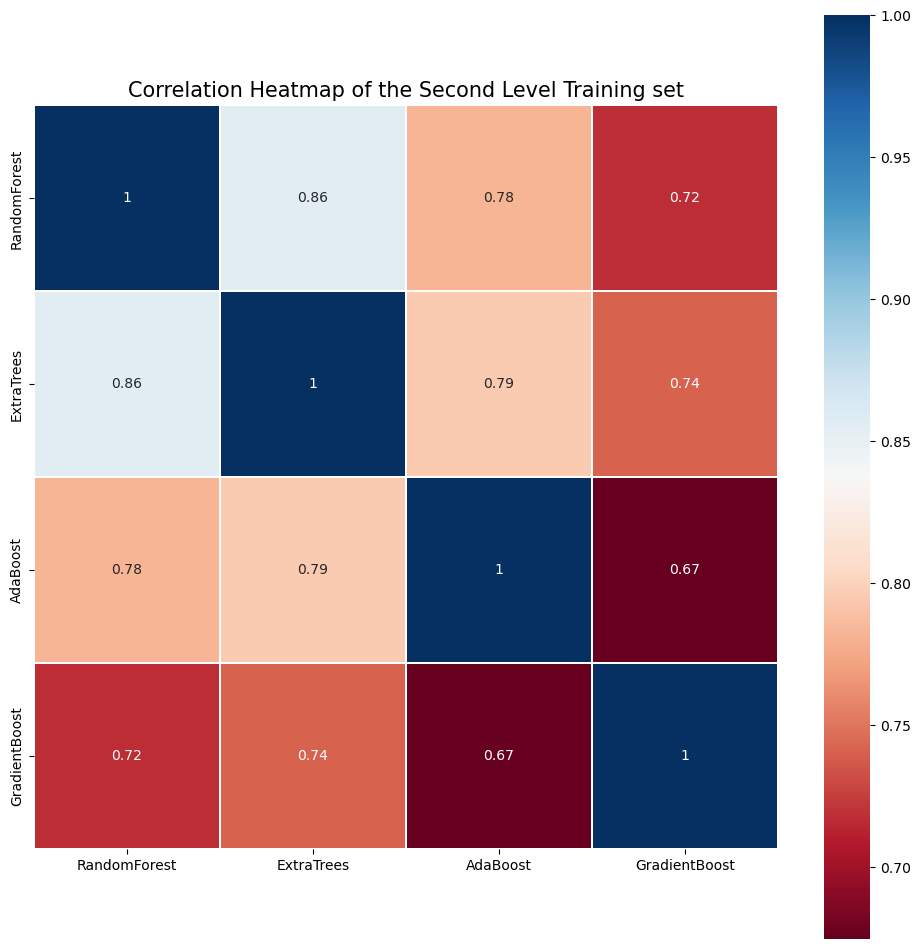

In [25]:
colormap = plt.cm.RdBu
plt.figure(figsize = (12, 12))
plt.title('Correlation Heatmap of the Second Level Training set', size = 15)
sns.heatmap(base_predictions_train.astype(float).corr(),
            linewidths = 0.1,
            vmax = 1.0,
            square = True,
            cmap = colormap,
            linecolor = 'white',
            annot = True)
plt.show()

In [26]:
# Creates a new set of training and test data from the previous results results
xx_train = np.concatenate(
    (et_oof_train,
     rf_oof_train,
     ada_oof_train,
     gb_oof_train,
     svc_oof_train),
    axis = 1)
xx_test = np.concatenate(
    (et_oof_test,
     rf_oof_test,
     ada_oof_test,
     gb_oof_test,
     svc_oof_test),
    axis = 1)

## Second Level learning model via XGBoost

The **XGBoost** was built to optimize large-scale boosted tree algorithms.

The XGBoost parameters used in the model:

- **max_depth**: How deep to grow the tree. Runs the risk of overfitting if set to too high.
- **gamma**: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.
- **eta**: Step size shrinkage used in each boosting step to prevent overfitting.

In [27]:
gbm = xgb.XGBClassifier(
#     learning_rate = 0.02,
    n_estimators = 2000,
    max_depth = 4,
    min_child_weight = 2,
#     gamma = 1,
    gamma = 0.9,                        
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = -1,
    scale_pos_weight = 1)

In [28]:
gbm.fit(xx_train, y_train)
predictions = gbm.predict_proba(xx_train)[:,1]

Accuracy : 0.8653 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8491 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7895 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8792                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


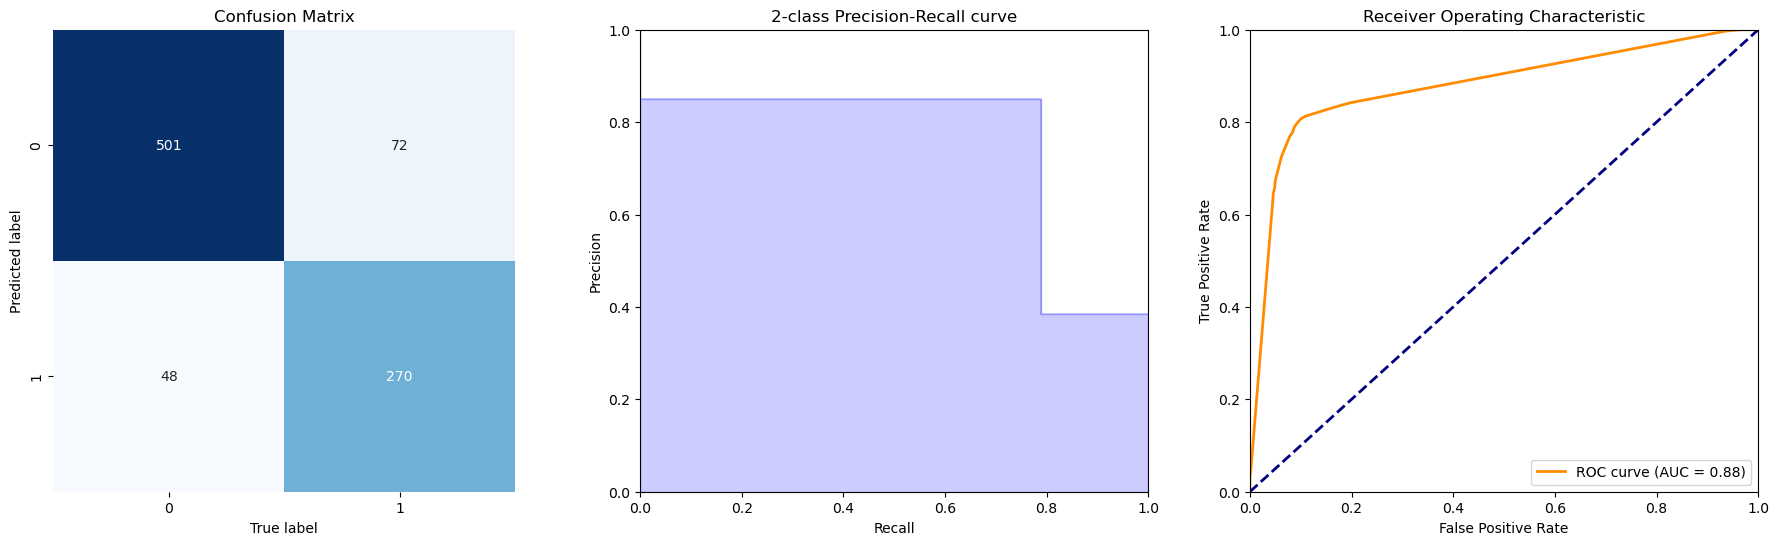

In [29]:
accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_train, predictions)
# keep the results
results.loc[len(results)] = {
    'Model': 'XGBoost', 
    'Accuracy': accuracy_, 
    'Precision': precision_,
    'Recall': recall_,
    'ROC_AUC': roc_auc_}
print()

In [30]:
results

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Random Forest,0.865320,0.844720,0.795322,0.920259
1,Extra Trees,0.869809,0.876667,0.769006,0.936104
2,AdaBoost,0.840629,0.814465,0.757310,0.903091
3,Gradient Boost,0.982043,0.990964,0.961988,0.999228
4,Support Vector Classifier,0.813692,0.765060,0.742690,0.850126
5,XGBoost,0.865320,0.849057,0.789474,0.879172




---



---



> > > > > > > > > © 2022 Institute of Data


---



---



